In [37]:
import xgboost as xgb
import holidays
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [58]:
df = pd.read_csv('data/2yrs_data.csv')
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...,...
1070561,2008-12-31,23:55:00,0.484,0.064,247.69,2.2,0.0,0.0,0.0
1070562,2008-12-31,23:56:00,0.482,0.064,247.35,2.2,0.0,0.0,0.0
1070563,2008-12-31,23:57:00,0.482,0.064,246.99,2.2,0.0,0.0,0.0
1070564,2008-12-31,23:58:00,0.480,0.064,246.52,2.2,0.0,0.0,0.0


# Baseline without feature engineering (R-square = 0.169)

In [39]:
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour  
df['Minute'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.minute 
df['Day'] = pd.to_datetime(df['Date']).dt.day                      
df['Month'] = pd.to_datetime(df['Date']).dt.month                 
df['Year'] = pd.to_datetime(df['Date']).dt.year  

df['hourly_active_power'] = df.groupby(['Year','Month','Day','Hour'])['Global_active_power'].transform('sum')
scaler = StandardScaler()
df['hourly_active_power'] = scaler.fit_transform(df[['hourly_active_power']])

df_proceesed = df.copy()
df_proceesed= df_proceesed.drop(columns=['Date', 'Time','Minute','Global_active_power','Global_reactive_power','Global_intensity','Voltage','Sub_metering_1','Sub_metering_2','Sub_metering_3'],).reset_index()
df_proceesed = df_proceesed.drop(columns=['index']).drop_duplicates().reset_index(drop=True)
df_proceesed

,Hour,Day,Month,Year,hourly_active_power
0,17,16,12,2006,1.473765
1,18,16,12,2006,2.611426
2,19,16,12,2006,2.371182
3,20,16,12,2006,2.234818
4,21,16,12,2006,2.015150
...,...,...,...,...,...
17844,19,31,12,2008,2.115162
17845,20,31,12,2008,3.177702
17846,21,31,12,2008,0.947190
17847,22,31,12,2008,-0.066707


In [40]:
train_size = int(len(df_proceesed) * 0.8)  # 80% for training
train = df_proceesed.iloc[:train_size]
test = df_proceesed.iloc[train_size:]

X_train = train.drop('hourly_active_power', axis=1)  # Features
y_train = train['hourly_active_power']               # Target
X_test = test.drop('hourly_active_power', axis=1)    # Features
y_test = test['hourly_active_power']      

In [41]:
train_dmatrix = xgb.DMatrix(X_train, label=y_train)
test_dmatrix = xgb.DMatrix(X_test, label=y_test)

In [42]:
params = {
    'objective': 'reg:squarederror',  # Regression problem
    'max_depth': 30,                  # Tree depth
    'eta': 0.01,                      # Learning rate
    'seed': 42
}

evals_result = {}

model = xgb.train(params, 
                  train_dmatrix, 
                  num_boost_round=1000,
                  evals=[(train_dmatrix, 'train'), (test_dmatrix, 'test')],
                  evals_result=evals_result,
                  early_stopping_rounds=10,  # Stop if no improvement after 10 rounds
                  verbose_eval=False)
y_pred = model.predict(test_dmatrix)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_squared = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r_squared:.4f}")

RMSE: 0.8659
R-squared: 0.1699


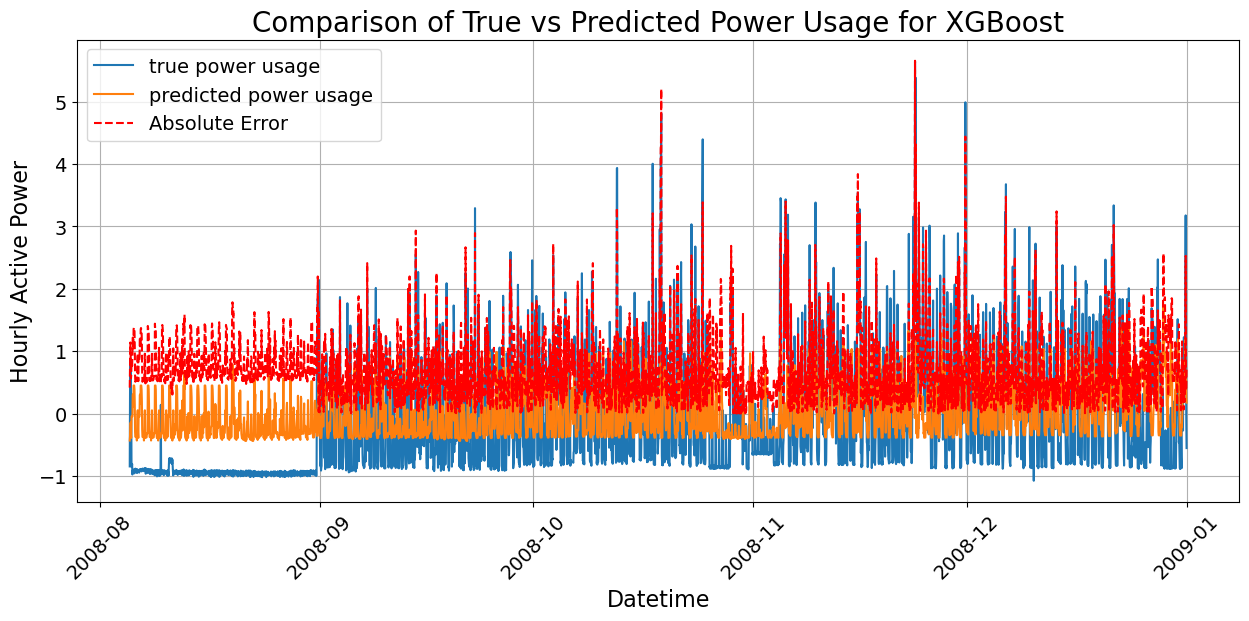

In [43]:
X_test['datetime'] = pd.to_datetime(X_test[['Year', 'Month', 'Day', 'Hour']])
error = np.abs(y_test - y_pred) 

plt.figure(figsize=(15, 6))
plt.plot(X_test['datetime'],y_test,  linestyle='-',label = 'true power usage')
plt.plot(X_test['datetime'],y_pred,  linestyle='-', label = 'predicted power usage')
plt.plot(X_test['datetime'], error, label='Absolute Error', color='red', linestyle='--')
plt.title('Comparison of True vs Predicted Power Usage for XGBoost', fontsize = 20)
plt.xlabel('Datetime', fontsize = 16)
plt.ylabel('Hourly Active Power', fontsize = 16)
plt.grid(True)
plt.legend(fontsize=14)
plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# XGBoost with feature engineering (R-square = 0.25)

In [147]:
df = pd.read_csv('data/2yrs_data.csv')
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...,...
1070561,2008-12-31,23:55:00,0.484,0.064,247.69,2.2,0.0,0.0,0.0
1070562,2008-12-31,23:56:00,0.482,0.064,247.35,2.2,0.0,0.0,0.0
1070563,2008-12-31,23:57:00,0.482,0.064,246.99,2.2,0.0,0.0,0.0
1070564,2008-12-31,23:58:00,0.480,0.064,246.52,2.2,0.0,0.0,0.0


In [148]:
df['Date'] = pd.to_datetime(df['Date'])
df['is_weekend'] = df['Date'].dt.weekday.isin([5, 6]).astype(int)

fr_holidays = holidays.France(years=range(2006, 2010))
df['is_holiday'] = df['Date'].isin(fr_holidays).astype(int)

df['day_of_week'] = df['Date'].dt.dayofweek

df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,is_weekend,is_holiday,day_of_week
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,1,0,5
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,1,0,5
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,1,0,5
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,1,0,5
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1070561,2008-12-31,23:55:00,0.484,0.064,247.69,2.2,0.0,0.0,0.0,0,0,2
1070562,2008-12-31,23:56:00,0.482,0.064,247.35,2.2,0.0,0.0,0.0,0,0,2
1070563,2008-12-31,23:57:00,0.482,0.064,246.99,2.2,0.0,0.0,0.0,0,0,2
1070564,2008-12-31,23:58:00,0.480,0.064,246.52,2.2,0.0,0.0,0.0,0,0,2


In [149]:
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour  
df['Minute'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.minute 
df['Day'] = pd.to_datetime(df['Date']).dt.day                      
df['Month'] = pd.to_datetime(df['Date']).dt.month                 
df['Year'] = pd.to_datetime(df['Date']).dt.year  

df['hour_day'] = df['Hour'] * df['Day']
# season_mapping = {
#     12: 1, 1: 1, 2: 1,
#     3: 2, 4: 2, 5: 2,
#     6: 3, 7: 3, 8: 3,
#     9: 4, 10: 4, 11: 4
# }

hour_mapping = {
    0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6:1,
    7: 2, 8: 2, 9: 2, 10: 2, 11: 2, 12: 2, 13: 2, 14: 2, 15: 2, 16: 2,
    17: 3, 18: 3, 19: 3, 20: 3, 21: 3,
    22: 4, 23: 4
}
df['hourly_mapping'] = df['Hour'].map(hour_mapping)

df['hourly_active_power'] = df.groupby(['Year','Month','Day','Hour'])['Global_active_power'].transform('sum')

scaler = StandardScaler()
df['hourly_active_power'] = scaler.fit_transform(df[['hourly_active_power']])

df_proceesed = df.copy()


df_proceesed= df_proceesed.drop(columns=['Date', 'Time','Minute','Global_active_power','Global_reactive_power','Global_intensity','Voltage','Sub_metering_1','Sub_metering_2','Sub_metering_3'],).reset_index()
df_proceesed = df_proceesed.drop(columns=['index']).drop_duplicates().reset_index(drop=True)
df_proceesed




,is_weekend,is_holiday,day_of_week,Hour,Day,Month,Year,hour_day,hourly_mapping,hourly_active_power
0,1,0,5,17,16,12,2006,272,3,1.473765
1,1,0,5,18,16,12,2006,288,3,2.611426
2,1,0,5,19,16,12,2006,304,3,2.371182
3,1,0,5,20,16,12,2006,320,3,2.234818
4,1,0,5,21,16,12,2006,336,3,2.015150
...,...,...,...,...,...,...,...,...,...,...
17844,0,0,2,19,31,12,2008,589,3,2.115162
17845,0,0,2,20,31,12,2008,620,3,3.177702
17846,0,0,2,21,31,12,2008,651,3,0.947190
17847,0,0,2,22,31,12,2008,682,4,-0.066707


In [150]:
train_size = int(len(df_proceesed) * 0.8)  # 80% for training
train = df_proceesed.iloc[:train_size]
test = df_proceesed.iloc[train_size:]

X_train = train.drop('hourly_active_power', axis=1)  # Features
y_train = train['hourly_active_power']               # Target
X_test = test.drop('hourly_active_power', axis=1)    # Features
y_test = test['hourly_active_power']                 # Target

In [151]:
train_dmatrix = xgb.DMatrix(X_train, label=y_train)
test_dmatrix = xgb.DMatrix(X_test, label=y_test)

In [152]:
params = {
    'objective': 'reg:squarederror',  # Regression problem
    'max_depth': 30,                  # Tree depth
    'eta': 0.01,                      # Learning rate
    'seed': 42
}

evals_result = {}

model = xgb.train(params, 
                  train_dmatrix, 
                  num_boost_round=1000,
                  evals=[(train_dmatrix, 'train'), (test_dmatrix, 'test')],
                  evals_result=evals_result,
                  early_stopping_rounds=10,  # Stop if no improvement after 10 rounds
                  verbose_eval=False)
y_pred = model.predict(test_dmatrix)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_squared = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r_squared:.4f}")

RMSE: 0.8222
R-squared: 0.2515


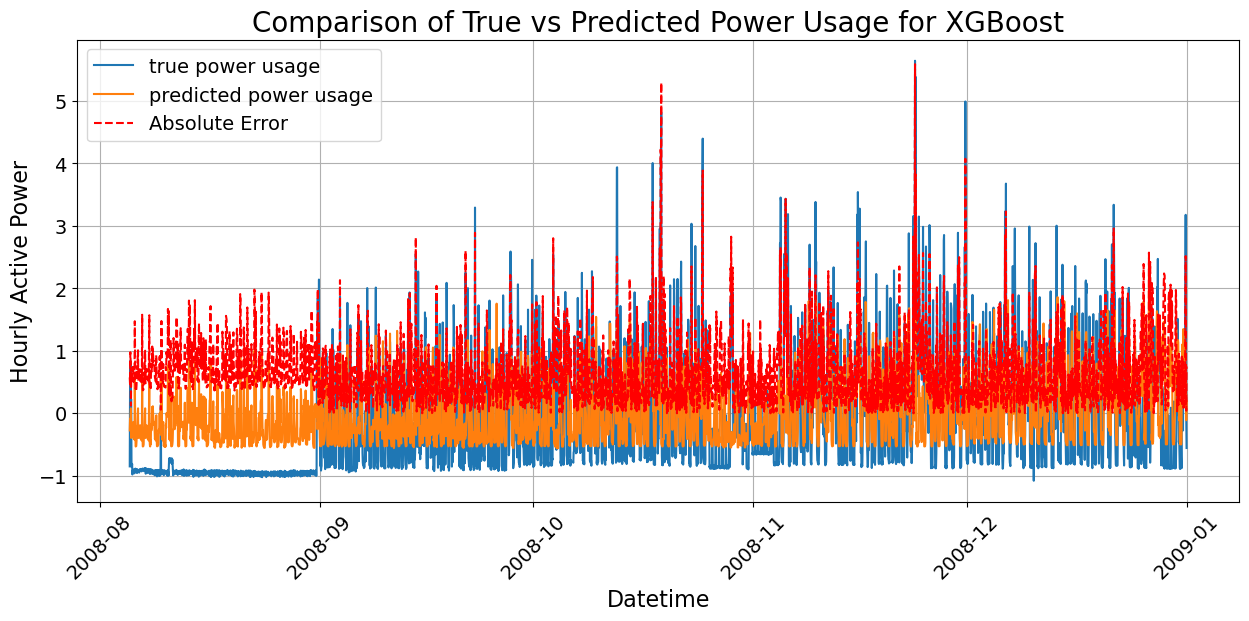

In [153]:
X_test['datetime'] = pd.to_datetime(X_test[['Year', 'Month', 'Day', 'Hour']])
error = np.abs(y_test - y_pred) 

plt.figure(figsize=(15, 6))
plt.plot(X_test['datetime'],y_test,  linestyle='-',label = 'true power usage')
plt.plot(X_test['datetime'],y_pred,  linestyle='-', label = 'predicted power usage')
plt.plot(X_test['datetime'], error, label='Absolute Error', color='red', linestyle='--')
plt.title('Comparison of True vs Predicted Power Usage for XGBoost', fontsize = 20)
plt.xlabel('Datetime', fontsize = 16)
plt.ylabel('Hourly Active Power', fontsize = 16)
plt.grid(True)
plt.legend(fontsize=14)
plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=14)
plt.show()

# Autoregressive (Worse: R-square  0.1)


In [109]:
df = pd.read_csv('data/2yrs_data.csv')
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...,...
1070561,2008-12-31,23:55:00,0.484,0.064,247.69,2.2,0.0,0.0,0.0
1070562,2008-12-31,23:56:00,0.482,0.064,247.35,2.2,0.0,0.0,0.0
1070563,2008-12-31,23:57:00,0.482,0.064,246.99,2.2,0.0,0.0,0.0
1070564,2008-12-31,23:58:00,0.480,0.064,246.52,2.2,0.0,0.0,0.0


In [110]:
df['Date'] = pd.to_datetime(df['Date'])
df['is_weekend'] = df['Date'].dt.weekday.isin([5, 6]).astype(int)
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,is_weekend
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,1
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,1
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,1
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,1
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,1
...,...,...,...,...,...,...,...,...,...,...
1070561,2008-12-31,23:55:00,0.484,0.064,247.69,2.2,0.0,0.0,0.0,0
1070562,2008-12-31,23:56:00,0.482,0.064,247.35,2.2,0.0,0.0,0.0,0
1070563,2008-12-31,23:57:00,0.482,0.064,246.99,2.2,0.0,0.0,0.0,0
1070564,2008-12-31,23:58:00,0.480,0.064,246.52,2.2,0.0,0.0,0.0,0


In [111]:
fr_holidays = holidays.France(years=range(2006, 2010))
df['is_holiday'] = df['Date'].isin(fr_holidays).astype(int)

df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,is_weekend,is_holiday
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,1,0
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,1,0
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,1,0
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,1,0
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1070561,2008-12-31,23:55:00,0.484,0.064,247.69,2.2,0.0,0.0,0.0,0,0
1070562,2008-12-31,23:56:00,0.482,0.064,247.35,2.2,0.0,0.0,0.0,0,0
1070563,2008-12-31,23:57:00,0.482,0.064,246.99,2.2,0.0,0.0,0.0,0,0
1070564,2008-12-31,23:58:00,0.480,0.064,246.52,2.2,0.0,0.0,0.0,0,0


In [112]:
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour  
df['Minute'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.minute 
df['Day'] = pd.to_datetime(df['Date']).dt.day                      
df['Month'] = pd.to_datetime(df['Date']).dt.month                 
df['Year'] = pd.to_datetime(df['Date']).dt.year  

df['hourly_active_power'] = df.groupby(['Year','Month','Day','Hour'])['Global_active_power'].transform('sum')

scaler = StandardScaler()
df['hourly_active_power'] = scaler.fit_transform(df[['hourly_active_power']])


df_proceesed = df.copy()


df_proceesed= df_proceesed.drop(columns=['Date', 'Time','Minute','Global_active_power','Global_reactive_power','Global_intensity','Voltage','Sub_metering_1','Sub_metering_2','Sub_metering_3'],).reset_index()
df_proceesed = df_proceesed.drop(columns=['index']).drop_duplicates().reset_index(drop=True)
df_proceesed




,is_weekend,is_holiday,Hour,Day,Month,Year,hourly_active_power
0,1,0,17,16,12,2006,1.473765
1,1,0,18,16,12,2006,2.611426
2,1,0,19,16,12,2006,2.371182
3,1,0,20,16,12,2006,2.234818
4,1,0,21,16,12,2006,2.015150
...,...,...,...,...,...,...,...
17844,0,0,19,31,12,2008,2.115162
17845,0,0,20,31,12,2008,3.177702
17846,0,0,21,31,12,2008,0.947190
17847,0,0,22,31,12,2008,-0.066707


In [96]:
N_LAGS = 10  # Number of lag features to create
for lag in range(1, N_LAGS + 1):
    df_proceesed[f'lag_{lag}'] = df['hourly_active_power'].shift(lag)


df_proceesed['rolling_mean_10'] = df_proceesed['hourly_active_power'].rolling(window=N_LAGS).mean()
df_proceesed['rolling_std_10'] = df_proceesed['hourly_active_power'].rolling(window=N_LAGS).std()

df_proceesed.dropna(inplace=True)

df_proceesed

,is_weekend,is_holiday,Hour,Day,Month,Year,hourly_active_power,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean_10,rolling_std_10
10,1,0,3,17,12,2006,0.571135,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,1.552808,0.830804
11,1,0,4,17,12,2006,1.144453,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,1.406111,0.748555
12,1,0,5,17,12,2006,0.917604,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,1.260753,0.678150
13,1,0,6,17,12,2006,0.199429,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,1.057214,0.658476
14,1,0,7,17,12,2006,0.527463,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,1.473765,0.908446,0.581568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17844,0,0,19,31,12,2008,2.115162,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,0.663945,0.676916
17845,0,0,20,31,12,2008,3.177702,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,0.998236,0.979678
17846,0,0,21,31,12,2008,0.947190,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.120322,0.873927
17847,0,0,22,31,12,2008,-0.066707,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.025937,0.950705


In [97]:
train_size = int(len(df_proceesed) * 0.8)  # 80% for training
train = df_proceesed.iloc[:train_size]
test = df_proceesed.iloc[train_size:]

X_train = train.drop('hourly_active_power', axis=1)  # Features
y_train = train['hourly_active_power']               # Target
# X_test = test.drop(['hourly_active_power','lag_1','lag_2','rolling_mean_2','rolling_std_2'], axis=1)    # Features
X_test = test.drop('hourly_active_power', axis=1)    # Features
y_test = test['hourly_active_power']                 # Target

In [98]:
X_test

,is_weekend,is_holiday,Hour,Day,Month,Year,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean_10,rolling_std_10
14281,0,0,8,5,8,2008,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,-0.306778,0.703368
14282,0,0,9,5,8,2008,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,-0.289675,0.730795
14283,0,0,10,5,8,2008,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,-0.271478,0.741619
14284,0,0,11,5,8,2008,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,-0.172529,0.734199
14285,0,0,12,5,8,2008,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,1.573052,-0.175992,0.737667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17844,0,0,19,31,12,2008,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,0.663945,0.676916
17845,0,0,20,31,12,2008,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,0.998236,0.979678
17846,0,0,21,31,12,2008,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.120322,0.873927
17847,0,0,22,31,12,2008,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.078031,1.025937,0.950705


In [99]:
train_dmatrix = xgb.DMatrix(X_train, label=y_train)
# val_dmatrix = xgb.DMatrix(X_val, label=y_val)
test_dmatrix = xgb.DMatrix(X_test, label=y_test)

In [100]:
# Train the model
model = xgb.train(
    params,
    train_dmatrix,
    num_boost_round=1000,
    verbose_eval=False
)


In [101]:
test_predictions = []

# Use the last known values from the training set to initialize the sliding window
last_known_values = X_train.iloc[-1].copy()  # Get the last row of the training set
lag_window = list(last_known_values[['lag_1', 'lag_2','lag_3', 'lag_4','lag_5','lag_6', 'lag_7','lag_8', 'lag_9','lag_10']])  # Start with lag_1 and lag_2
print("Initial Lag Window:", lag_window)

# Extend lag_window to include up to 10 lags
while len(lag_window) < 10:
    lag_window.append(0)  # Pad with zeros or any initialization value

# Iterate over each sample in the test set
# Iterate over each sample in the test set
for i in range(len(X_test)):
    # Prepare current_features entirely from the sliding window (not X_test)
    current_features = pd.DataFrame([{
        'is_weekend': 0,  # Replace with actual test-specific static features if needed
        'is_holiday': 0,  # Replace with actual test-specific static features if needed
        'Hour': X_test.iloc[i]['Hour'],  # Use static test-specific features (e.g., Hour)
        'Day': X_test.iloc[i]['Day'],    # Use static test-specific features (e.g., Day)
        'Month': X_test.iloc[i]['Month'],# Use static test-specific features (e.g., Month)
        'Year': X_test.iloc[i]['Year'],  # Use static test-specific features (e.g., Year)
        'lag_1': lag_window[-1],         # Dynamically updated lag_1
        'lag_2': lag_window[-2],         # Dynamically updated lag_2
        'lag_3': lag_window[-3],         # Dynamically updated lag_3
        'lag_4': lag_window[-4],         # Dynamically updated lag_4
        'lag_5': lag_window[-5],         # Dynamically updated lag_5
        'lag_6': lag_window[-6],         # Dynamically updated lag_1
        'lag_7': lag_window[-7],         # Dynamically updated lag_2
        'lag_8': lag_window[-8],         # Dynamically updated lag_3
        'lag_9': lag_window[-9],         # Dynamically updated lag_4
        'lag_10': lag_window[-10],         # Dynamically updated lag_5
        'rolling_mean_10': np.mean(lag_window[-10:]),  # Example rolling mean over last 2 lags
        'rolling_std_10': np.std(lag_window[-10:])     # Example rolling std over last 2 lags
    }])

    # Create a DMatrix for the current sample
    test_sample = xgb.DMatrix(current_features.values, feature_names=current_features.columns.tolist())
    
    # Predict the current sample
    pred = model.predict(test_sample)[0]
    test_predictions.append(pred)  # Store the prediction

    # Slide the window: Update the lagged values in lag_window
    lag_window.append(pred)  # Add the new prediction to the window
    if len(lag_window) > 5:
        lag_window.pop(0)  # Ensure the lag window always has the latest 2 lags
    

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
r_squared = r2_score(y_test, test_predictions)
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r_squared:.4f}")

Initial Lag Window: [1.5730522718830242, 1.5730522718830242, 1.5730522718830242, 1.5730522718830242, 1.5730522718830242, 1.5730522718830242, 1.5730522718830242, 1.5730522718830242, 1.5730522718830242, 1.5730522718830242]
RMSE: 0.8980
R-squared: 0.1074


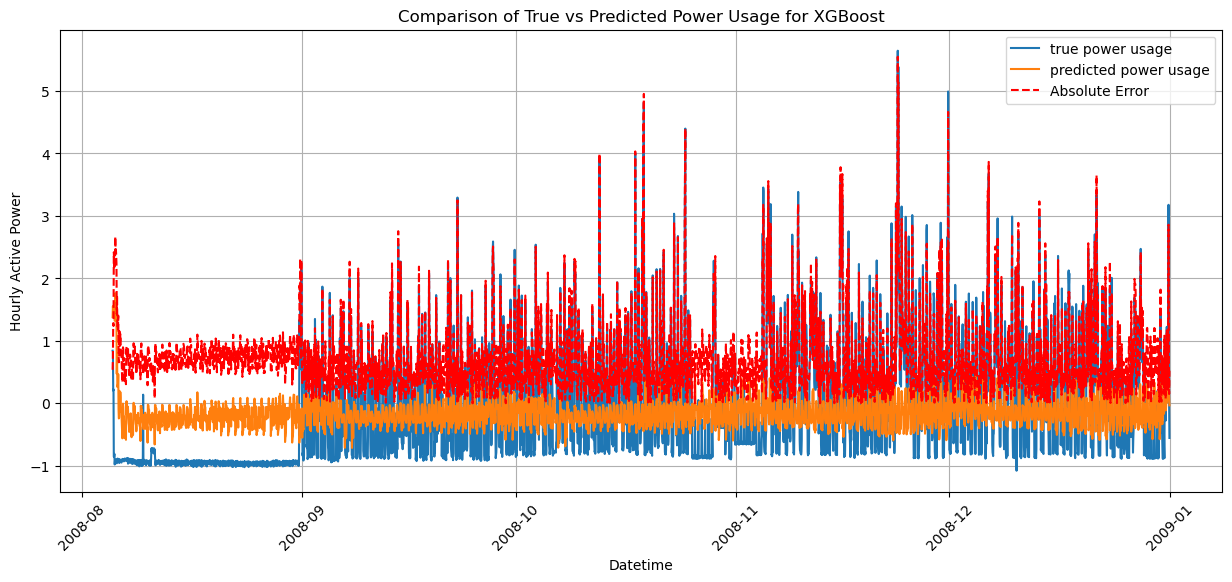

In [103]:
X_test['datetime'] = pd.to_datetime(X_test[['Year', 'Month', 'Day', 'Hour']])
error = np.abs(y_test - test_predictions) 

plt.figure(figsize=(15, 6))
plt.plot(X_test['datetime'],y_test,  linestyle='-',label = 'true power usage')
plt.plot(X_test['datetime'],test_predictions,  linestyle='-', label = 'predicted power usage')
plt.plot(X_test['datetime'], error, label='Absolute Error', color='red', linestyle='--')
plt.title('Comparison of True vs Predicted Power Usage for XGBoost')
plt.xlabel('Datetime')
plt.ylabel('Hourly Active Power')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()

# with 2-hour window, turns out to be data leakage

In [136]:
df = pd.read_csv('data/2yrs_data.csv')
df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0
...,...,...,...,...,...,...,...,...,...
1070561,2008-12-31,23:55:00,0.484,0.064,247.69,2.2,0.0,0.0,0.0
1070562,2008-12-31,23:56:00,0.482,0.064,247.35,2.2,0.0,0.0,0.0
1070563,2008-12-31,23:57:00,0.482,0.064,246.99,2.2,0.0,0.0,0.0
1070564,2008-12-31,23:58:00,0.480,0.064,246.52,2.2,0.0,0.0,0.0


In [137]:
df['Date'] = pd.to_datetime(df['Date'])
df['is_weekend'] = df['Date'].dt.weekday.isin([5, 6]).astype(int)

fr_holidays = holidays.France(years=range(2006, 2010))
df['is_holiday'] = df['Date'].isin(fr_holidays).astype(int)


df

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,is_weekend,is_holiday
0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,1,0
1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,1,0
2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,1,0
3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,1,0
4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1070561,2008-12-31,23:55:00,0.484,0.064,247.69,2.2,0.0,0.0,0.0,0,0
1070562,2008-12-31,23:56:00,0.482,0.064,247.35,2.2,0.0,0.0,0.0,0,0
1070563,2008-12-31,23:57:00,0.482,0.064,246.99,2.2,0.0,0.0,0.0,0,0
1070564,2008-12-31,23:58:00,0.480,0.064,246.52,2.2,0.0,0.0,0.0,0,0


In [138]:
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour  
df['Minute'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.minute 
df['Day'] = pd.to_datetime(df['Date']).dt.day                      
df['Month'] = pd.to_datetime(df['Date']).dt.month                 
df['Year'] = pd.to_datetime(df['Date']).dt.year  

df['hourly_active_power'] = df.groupby(['Year','Month','Day','Hour'])['Global_active_power'].transform('sum')

scaler = StandardScaler()
df['hourly_active_power'] = scaler.fit_transform(df[['hourly_active_power']])


df_proceesed = df.copy()

df_proceesed= df_proceesed.drop(columns=['Date', 'Time','Minute','Global_active_power','Global_reactive_power','Global_intensity','Voltage','Sub_metering_1','Sub_metering_2','Sub_metering_3'],).reset_index()
df_proceesed = df_proceesed.drop(columns=['index']).drop_duplicates().reset_index(drop=True)
df_proceesed




,is_weekend,is_holiday,Hour,Day,Month,Year,hourly_active_power
0,1,0,17,16,12,2006,1.473765
1,1,0,18,16,12,2006,2.611426
2,1,0,19,16,12,2006,2.371182
3,1,0,20,16,12,2006,2.234818
4,1,0,21,16,12,2006,2.015150
...,...,...,...,...,...,...,...
17844,0,0,19,31,12,2008,2.115162
17845,0,0,20,31,12,2008,3.177702
17846,0,0,21,31,12,2008,0.947190
17847,0,0,22,31,12,2008,-0.066707


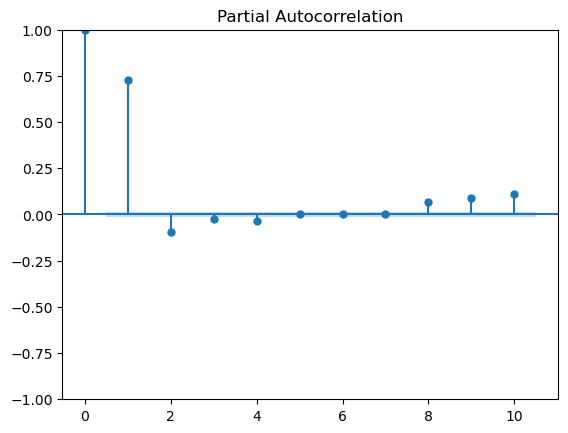

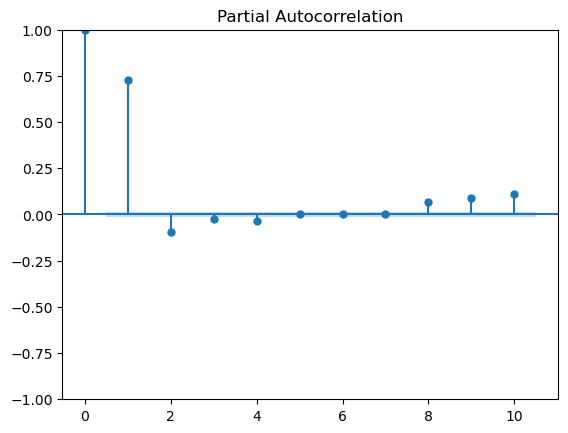

In [139]:
plot_pacf(df_proceesed['hourly_active_power'], lags=10)

In [140]:
N_LAGS = 2  # Number of lag features to create
for lag in range(1, N_LAGS + 1):
    df_proceesed[f'lag_{lag}'] = df['hourly_active_power'].shift(lag)


df_proceesed['rolling_mean_2'] = df_proceesed['hourly_active_power'].rolling(window=N_LAGS).mean()
df_proceesed['rolling_std_2'] = df_proceesed['hourly_active_power'].rolling(window=N_LAGS).std()

df_proceesed.dropna(inplace=True)

df_proceesed

,is_weekend,is_holiday,Hour,Day,Month,Year,hourly_active_power,lag_1,lag_2,rolling_mean_2,rolling_std_2
2,1,0,19,16,12,2006,2.371182,1.473765,1.473765,2.491304,0.169878
3,1,0,20,16,12,2006,2.234818,1.473765,1.473765,2.303000,0.096424
4,1,0,21,16,12,2006,2.015150,1.473765,1.473765,2.124984,0.155329
5,1,0,22,16,12,2006,1.128262,1.473765,1.473765,1.571706,0.627125
6,1,0,23,16,12,2006,0.984786,1.473765,1.473765,1.056524,0.101453
...,...,...,...,...,...,...,...,...,...,...,...
17844,0,0,19,31,12,2008,2.115162,1.078031,1.078031,1.386198,1.030911
17845,0,0,20,31,12,2008,3.177702,1.078031,1.078031,2.646432,0.751329
17846,0,0,21,31,12,2008,0.947190,1.078031,1.078031,2.062446,1.577210
17847,0,0,22,31,12,2008,-0.066707,1.078031,1.078031,0.440242,0.716933


In [141]:
train_size = int(len(df_proceesed) * 0.8)  # 80% for training
train = df_proceesed.iloc[:train_size]
test = df_proceesed.iloc[train_size:]

X_train = train.drop('hourly_active_power', axis=1)  # Features
y_train = train['hourly_active_power']               # Target
X_test = test.drop('hourly_active_power', axis=1)    # Features
y_test = test['hourly_active_power']                 # Target

In [142]:
X_test

,is_weekend,is_holiday,Hour,Day,Month,Year,lag_1,lag_2,rolling_mean_2,rolling_std_2
14279,0,0,6,5,8,2008,1.573052,1.573052,-0.854963,0.009130
14280,0,0,7,5,8,2008,1.573052,1.573052,-0.234142,0.868845
14281,0,0,8,5,8,2008,1.573052,1.573052,0.611630,0.327257
14282,0,0,9,5,8,2008,1.573052,1.573052,0.832644,0.014696
14283,0,0,10,5,8,2008,1.573052,1.573052,0.513395,0.436790
...,...,...,...,...,...,...,...,...,...,...
17844,0,0,19,31,12,2008,1.078031,1.078031,1.386198,1.030911
17845,0,0,20,31,12,2008,1.078031,1.078031,2.646432,0.751329
17846,0,0,21,31,12,2008,1.078031,1.078031,2.062446,1.577210
17847,0,0,22,31,12,2008,1.078031,1.078031,0.440242,0.716933


In [143]:
train_dmatrix = xgb.DMatrix(X_train, label=y_train)
# val_dmatrix = xgb.DMatrix(X_val, label=y_val)
test_dmatrix = xgb.DMatrix(X_test, label=y_test)

In [144]:
params = {
    'objective': 'reg:squarederror',  # Regression problem
    'max_depth': 20,                  # Tree depth
    'eta': 0.01,                      # Learning rate
    'seed': 42
}

evals_result = {}

model = xgb.train(params, 
                  train_dmatrix, 
                  num_boost_round=1000,
                  evals=[(train_dmatrix, 'train'), (test_dmatrix, 'test')],
                  evals_result=evals_result,
                  early_stopping_rounds=10,  # Stop if no improvement after 10 rounds
                  verbose_eval=False)
y_pred = model.predict(test_dmatrix)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r_squared = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r_squared:.4f}")

RMSE: 0.3052
R-squared: 0.8969


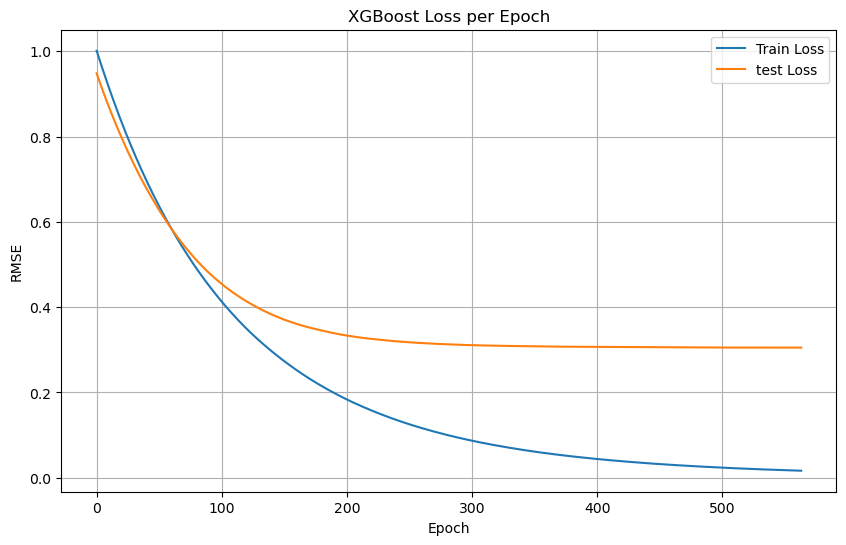

In [145]:
# Plot training and validation loss
epochs = len(evals_result['train']['rmse'])  # Number of epochs
x_axis = range(epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, evals_result['train']['rmse'], label='Train Loss')
plt.plot(x_axis, evals_result['test']['rmse'], label='test Loss')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('XGBoost Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

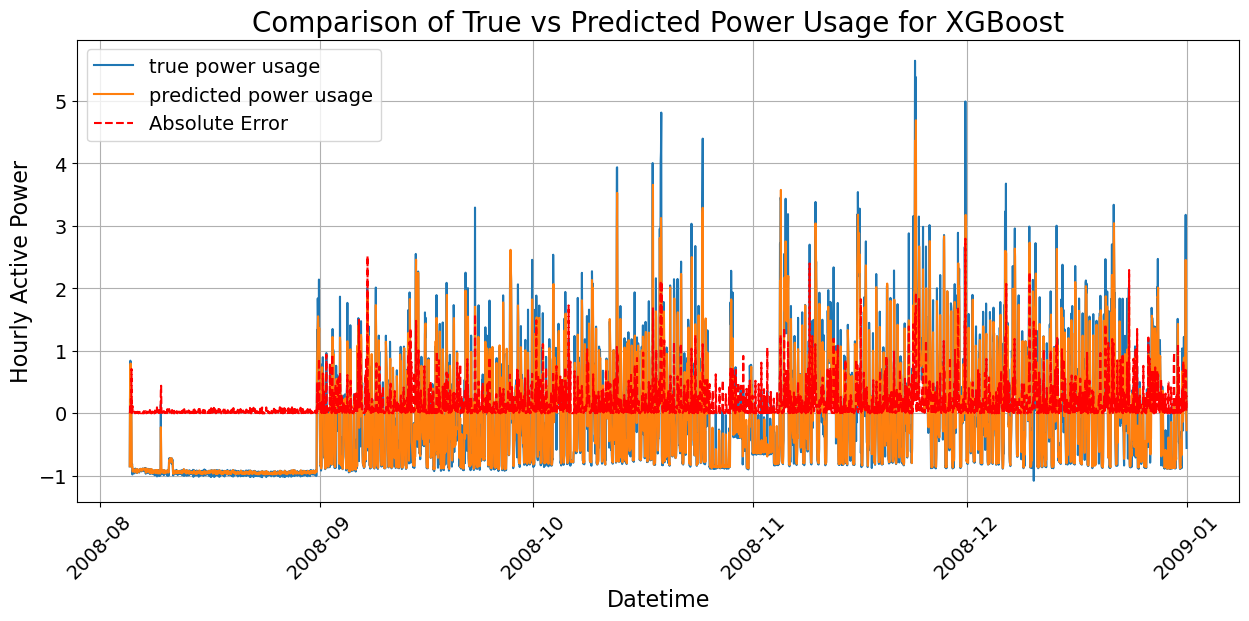

In [146]:
X_test['datetime'] = pd.to_datetime(X_test[['Year', 'Month', 'Day', 'Hour']])
error = np.abs(y_test - y_pred) 

plt.figure(figsize=(15, 6))
plt.plot(X_test['datetime'],y_test,  linestyle='-',label = 'true power usage')
plt.plot(X_test['datetime'],y_pred,  linestyle='-', label = 'predicted power usage')
plt.plot(X_test['datetime'], error, label='Absolute Error', color='red', linestyle='--')
plt.title('Comparison of True vs Predicted Power Usage for XGBoost', fontsize = 20)
plt.xlabel('Datetime', fontsize = 16)
plt.ylabel('Hourly Active Power', fontsize = 16)
plt.grid(True)
plt.legend(fontsize=14)
plt.xticks(rotation=45,fontsize=14)
plt.yticks(fontsize=14)
plt.show()